# Quantum Lab2: Phase estimation

## Part 1: Performance of Quantum Phase Estimation

Goal of this lab:

Investigate the relationship between the number of qubits required for the desired accuracy of the phase estimation with high probability.

The accuracy of the estimated value through Quantum Phase Estimation (QPE) and its probability of success depend on the number of qubits employed in QPE circuits. Therefore, one might want to know the necessary number of qubits to achieve the targeted level of QPE performance, especially when the phase that needs to be determined cannot be decomposed in a finite bit binary expansion. In Part 1 of this lab, we examine the number of qubits required to accomplish the desired accuracy and the probability of success in determining the phase through QPE.

In [2]:
from qiskit import *
from qiskit_aer import AerSimulator
import numpy as np
from qiskit.visualization import plot_histogram
import matplotlib.pyplot as plt
import math
from qiskit.circuit.library import QFT

In the following section, we want to do quantum phase estimation for gate $U_1(2\pi/3)$, with respect to eigen state $\ket{1}$

The following page give the definition of $U_1$ gate:
https://docs.quantum.ibm.com/api/qiskit/qiskit.circuit.library.U1Gate

### 1. Find the probability of obtaining the estimation for a phase value accurate to $2^{-2}$ successfully with four counting qubits.

You are already provided with the circuit of quantum fourier transform.
You can directly use qft function to build your circuit of quantum phase estimation

In [ ]:
def qft(n):
    """Creates an n-qubit QFT circuit"""
    circuit = QuantumCircuit(n)
    def swap_registers(circuit, n):
        for qubit in range(n//2):
            circuit.swap(qubit, n-qubit-1)
        return circuit
    def qft_rotations(circuit, n):
        """Performs qft on the first n qubits in circuit (without swaps)"""
        if n == 0:
            return circuit
        n -= 1
        circuit.h(n)
        for qubit in range(n):
            circuit.cp(np.pi/2**(n-qubit), qubit, n)
        qft_rotations(circuit, n)
    
    qft_rotations(circuit, n)
    swap_registers(circuit, n)
    return circuit

#### 1.Step A. Set up the QPE circuit with four counting qubits and save the circuit to the variable 'qc4'. Execute 'qc4' on a qasm simulator. Plot the histogram of the result.

In [ ]:
## Start your code to create the circuit, qc4
## Keep in mind that the target unitary is U_1(2\pi/3), and the eigen state is |1>


qc4.draw()

In [ ]:
## Run this cell to simulate 'qc4' and to plot the histogram of the result
sim = AerSimulator()
shots = 20000
transpiled_circuit = transpile(qc4, sim)
job = sim.run(transpiled_circuit, shots=1000) # Run the circuit 1000 times 
count_qc4 = job.result().get_counts() 



plot_histogram(count_qc4, figsize=(9,5))

Having performed Step A successfully, you will have obtained a distribution similar to the one shown below with the highest probability at 0101 which corresponds to the estimated $\phi$ value, $0.3125$

![title](Figure/L5_qc4_hist.png)

Since the number of counting qubits used for the circuit is four, the best estimated value should be accurate to 
$\delta=2^{-4}=0.0625$. However, there are multiple possible outcomes as $\theta=1/3$ cannot be expressed in a finite number of bits, the estimation by QPE here is not always bounded by this accuracy.

Running the following cell shows the same histogram but with all possible estimated estimated $\phi$ values  on the x-axis

In [ ]:
t=4
phi_est = np.array([round(int(key, 2)/2**t,3) for key in list(count_qc4.keys())])
key_new = list(map(str, phi_est))
count_new = dict(zip(key_new, count_qc4.values()))
plot_histogram(count_new, figsize=(9,5))

Suppose the outcome of the final measurement is , and let the best estimation which is $0.3125$ for this case.

#### Step B. Find e, the maximum difference in integer from the best estimation 0101 so that all the outcomes, 'm's, would approximate $\phi$ to an accuracy $2^{-2}$ when $|m-b|\leq \frac{e}{2^t}$

In this case, the value of $t$ and $b$ are $4$ and $0.3125$, respectively.

For example, under $e=1$, the considered outcomes are 0100, 0101, 0110 which correspond to the values of $m$: 
$0.25,0.312,0.375$, respectively, and all of them approximate the value $\frac{1}{3}$ to an accuracy $2^{-2}$.

In [ ]:
# Your code goes here

#### Step C: Compute the probability of obtaining an approximation correct to an accuracy $2^{-2}$. Verify that the computed probability value is larger or equal to $1-\frac{1}{2(2^{(t-n)}-2)}$ where $t$ is the number of counting bits and the $2^{-n}$ is the desired accuracy.

Now it is easy to evaluate the probability of the success from the histogram since all the outcomes that approximate $\phi$ to the accuracy 
$2^{-2}$ can be found based on the maximum difference $e$ from the best estimate.

In [ ]:
# Your code goes here

### 2. Compute the probability of success for the accuracy $2^{-2}$, when the number of counting qubits $t$, varies from four to nine. Compare your result with the equation $t=n+\log(2+\frac{1}{2\epsilon})$ when $2^{-n}$ is the desired accuracy and $\epsilon$ is 1-probability of success

The following plot shows the relationship between the number of counting qubit, $t$, and the minimum probability of success to approximate the phase to an accuracy $2^{-2}$. Check the Ch. 5.2.1 Performance and requirements in [Michael A. Nielsen and Isaac L. Chuang. 2011. Quantum Computation and Quantum Information].

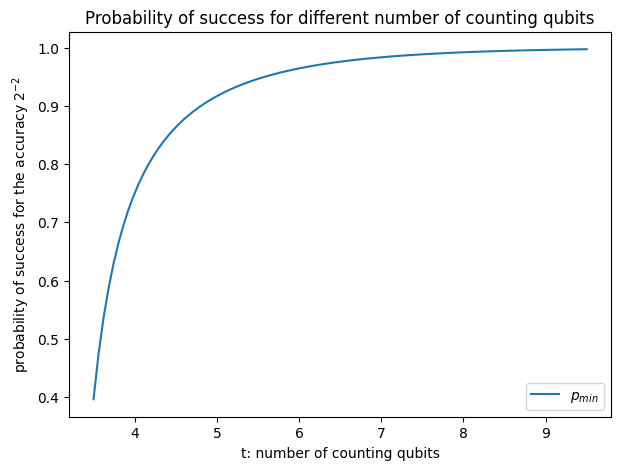

In [3]:
y = lambda t, n: 1-1/(2*(2**(t-n)-2))
t_q = np.linspace(3.5, 9.5, 100 )
p_min = y(t_q, 2)

plt.figure(figsize=(7, 5))
plt.plot(t_q, p_min, label='$p_{min}$')
plt.xlabel('t: number of counting qubits')
plt.ylabel('probability of success for the accuracy $2^{-2}$')
plt.legend(loc='lower right')
plt.title('Probability of success for different number of counting qubits')
plt.show()

#### Step A. Construct QPE circuit to estimate $\phi$ when $\phi=1/3$ with for the different number of counting qubits $t$ , when $t=[4,5,6,7,8,9]$. Store all the circuits in a list variable 'circ' to simulate all the circuits at once as we did in Lab3.

In [4]:
## Your Code to create the list variable 'circ' goes here

In [ ]:
# Run this cell to simulate `circ` and plot the histograms of the results

results = execute(circ, sim, shots=shots).result()

n_circ = len(circ)
counts = [results.get_counts(idx) for idx in range(n_circ)]

fig, ax = plt.subplots(n_circ,1,figsize=(25,40))
for idx in range(n_circ):
    plot_histogram(counts[idx], ax=ax[idx])
plt.tight_layout()

#### Step B. Determine $e$, the maximum difference in integer from the best estimation for the different numer of counting qubits, $t=[4,5,6,7,8,9]$. Verify the relationship $e=2^{t-n}-1$ where $n=2$ since the desired accuracy is $2^{-2}$ in this case.

In [6]:
## Your Code goes here

If you successfully calculated $e$ values for all the counting qubits $t=[4,5,6,7,8,9]$, you will be able to generate the following graph that verifies the relationship $e=2^{t-2}-1$ with the values that you computed.

![title](Figure/L5_e_max.png)

#### Step C. Evaluate the probability of success estimating $\phi$ to an accuracy $2^{-2}$ for all the values of $t$, the number of counting qubits. Save the probabilities to the list variable, 'prob_success'.

In [5]:
## Your Code goes here

#### Step D. Overlay the results of Step C on the graph that shows the relationship between the number of counting qubits $t$, and the minimum probability of success to approximate the phase to an accuracy $2^{-2}$. Understand the result.

In [7]:
## Your code goes here

![title](Figure/L5_prob_t.png)

Your plot should be similar to the above one. The line plot in the left pannel shows the minimum success probability to estimate $\phi$ within the accuracy $2^{-2}$ as the number of counting qubits varies. The overlayed orange dots are the same values, but from the simulation, which confirms the relationship the line plot represents as the lower bound. The right pannel displays the same result but zoomed by adjusting the y-axis range.

The following graph exhibits the relationships with different accuracy levels. The relationship, $t=n+\log(2+\frac{1}{2\epsilon})$, indicates the number of counting qubits $t$ to estimate $\phi$ to an accuracy $2^{-2}$ with probability of success at least $1-\epsilon$, as we validated above.

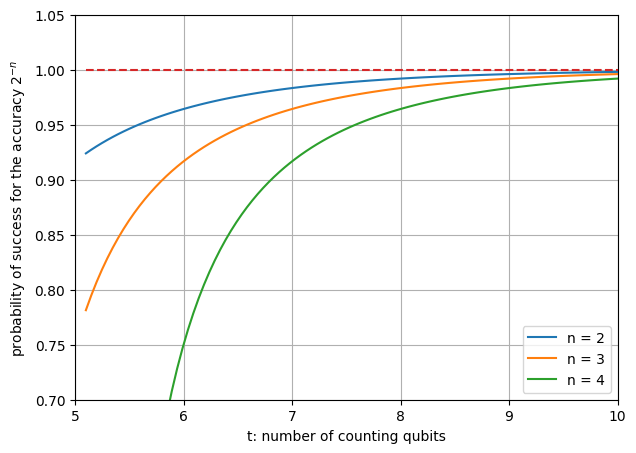

In [6]:
t = np.linspace(5.1, 10, 100)
prob_success_n = [y(t, n) for n in [2, 3, 4]]
prob_n2, prob_n3, prob_n4  = prob_success_n[0], prob_success_n[1], prob_success_n[2]

plt.figure(figsize=(7, 5))
plt.plot(t, prob_n2, t, prob_n3, t, prob_n4, t, [1]*len(t),'--' )
plt.axis([5, 10, 0.7, 1.05])
plt.xlabel('t: number of counting qubits')
plt.ylabel('probability of success for the accuracy $2^{-n}$')
plt.legend(['n = 2', 'n = 3', 'n = 4'], loc='lower right')
plt.grid(True)

# Part2. Use noisy fake quantum computer and redo the above experiment

Goal

Run the QPE circuit on a real quantum system to understand the result and limitations when using noisy quantum systems

The accuracy anaylsis that we performed in Part 1 would not be correct when the QPE circuit is executed on present day noisy quantum systems. In part 2, we will obtain QPE results by running the circuit on a fake backend to examine how noise affects the outcome and learn techniques to reduce its impact.

#### Step A: Import the fackbackend

In [ ]:
## Your code goes here

#### Step B. Generate multiple ( as many as you want ) transpiled circuits of qc4 that you set up in Part 1 at the beginning. Choose one with the minimum circuit depth, and the other with the maximum circuit depth.

Transpile the circuit with the parameter optimization_level = 3 to reduce the error in the result. As we learned in Lab 1, Qiskit by default uses a stochastic swap mapper to place the needed SWAP gates, which varies the tranpiled circuit results even under the same runtime settings. Therefore, to achieve shorter depth transpiled circuit for smaller error in the outcome, transpile qc4 multiple times and choose one with the minimum circuit depth. Select the maximum circuit depth one as well for comparison purposes.

In [ ]:
## Your code goes here

#### Step C. Execute both circuits on the fake backend. Plot the histogram for the results and compare them with the simulation result in Part 1.

In [ ]:
## Your code goes here

The following shows the sample result.

![title](Figure/L5_QPEresults.png)